### 1\. Il Design Architetturale: L'Input Layer e la Gestione delle Dimensioni

Nel Machine Learning classico (come con Scikit-Learn), spesso siamo abituati a passare i dati `X` al modello senza preoccuparci troppo della loro forma, finché il numero di colonne è coerente. Le Reti Neurali, però, sono molto più rigide. Una rete neurale non è altro che una sequenza di operazioni di algebra lineare (moltiplicazioni di matrici); se le dimensioni delle matrici non combaciano matematicamente, il codice non parte nemmeno.

Il primo passo per costruire una rete in Keras è definire esattamente cosa entra nel modello.

#### La "Porta d'Ingresso": Definire la Forma

Quando istanziate il primo layer (di solito un `Dense` o un `Conv2D`), Keras deve sapere quanti "fili" di input collegare. Questo si fa con l'argomento `input_shape`.

Immaginate di avere un dataset tabellare (come il prezzo delle case) con 13 colonne (features).
Ogni singolo esempio è un **vettore** di 13 numeri.

In Keras, questo si traduce così:

```python
model = Sequential([
    # Il primo layer DEVE sapere la forma dell'input.
    # Dense(32) significa che questo strato ha 32 neuroni.
    Dense(32, input_shape=(13,), activation='relu')
])
```

**Attenzione alla virgola:** Notate `(13,)`. Questa è una tupla in Python con un solo elemento.
State dicendo alla rete: *"Ogni singolo dato che ti passerò sarà un vettore monodimensionale lungo 13"*.


#### Il Grande Equivoco: Vettori vs Matrici (Flattening)

Cosa succede se invece di dati tabellari (1D) abbiamo un'immagine (2D)?
Immaginate un'immagine piccola in scala di grigi, $28 \times 28$ pixel (come nel dataset MNIST).

Un layer `Dense` (densamente connesso) è progettato per lavorare su vettori piatti, non su griglie. Ogni neurone deve essere collegato a *ogni singolo pixel*. Se provate a passare una matrice $28 \times 28$ direttamente a un layer `Dense`, Keras vi restituirà un errore di dimensione o, peggio, applicherà l'operazione in modo errato su ogni riga indipendentemente.

Dobbiamo "srotolare" l'immagine. Dobbiamo trasformare la matrice $28 \times 28$ in un unico lungo vettore di $784$ pixel ($28 \times 28 = 784$).
Questa operazione si chiama **Flattening**.

In Keras, questo diventa un layer esplicito, che non impara nulla (non ha parametri), ma trasforma solo i dati:

```python
model = Sequential([
    # Input: matrice 28x28
    Input(shape=(28, 28)), 
    
    # Trasforma (28, 28) -> (784,)
    Flatten(),             
    
    # Ora possiamo collegare i neuroni
    Dense(128, activation='relu') 
])
```

#### La Dimensione "Fantasma": Il Batch Size

Qui è dove molti principianti si confondono.
Se chiedete a Keras il `model.summary()` di una rete con `input_shape=(13,)`, vedrete che l'output shape è `(None, 13)`.

Perché `None`? E perché due dimensioni?

Le reti neurali non processano i dati uno alla volta (sarebbe lentissimo), ma a pacchetti chiamati **Batch**.
L'algebra interna della rete si aspetta una matrice dove:

1.  **Dimensione 0 (Righe):** Il numero di campioni nel batch (Batch Size).
2.  **Dimensione 1 (Colonne):** Le feature (13).

Il `None` è un segnaposto che significa: *"Accetto qualsiasi dimensione del batch"*.

  * Durante il training, potrei passargli un batch di 32 esempi: la forma reale sarà `(32, 13)`.
  * Durante la predizione su un singolo esempio, la forma sarà `(1, 13)`.

**Regola d'oro:** Quando progettate l'`input_shape`, ignorate sempre la dimensione del batch. Descrivete la forma di un *singolo* campione. Keras aggiungerà automaticamente la dimensione del batch come prima dimensione.

### 2\. Hidden Layers: Il Cuore dell'Astrazione

Una volta definiti gli ingressi, entriamo nel territorio dei **Hidden Layers**. È qui che avviene la vera "magia". Se l'input layer è la retina che cattura la luce, gli hidden layers sono la corteccia visiva che elabora il segnale.

La domanda che paralizza ogni praticante è: *Come scelgo la forma di questa struttura?*

#### Width: Quanti neuroni in uno strato? (Espansione vs Compressione)

Il numero di neuroni (l'argomento `units` in `Dense(units)`) definisce la **capacità** di quello specifico strato di rappresentare l'informazione.

Possiamo vedere questo numero come la dimensione dello "spazio delle feature" in cui stiamo proiettando i nostri dati. Ci sono due strategie opposte:

1.  **Espansione (Input \< Neuroni):**
    Immaginate di avere un input con 10 feature molto "aggrovigliate" tra loro (es. coordinate complesse). Se proiettiamo questi dati in uno spazio a dimensione più alta (es. 128 neuroni), diamo alla rete più "spazio di manovra" per separare i dati con iperpiani.

      * *Perché farlo:* Utile nei primi strati per estrarre quante più combinazioni/sfumature possibili dai dati grezzi. "Srotoliamo" i dati per vederli meglio.

2.  **Compressione (Input \> Neuroni):**
    Se passiamo da 128 neuroni a 32, stiamo creando un **Collo di Bottiglia (Bottleneck)** informativo.

      * *Perché farlo:* Costringiamo la rete a scartare il rumore e conservare solo le informazioni vitali. Se la rete deve rappresentare un concetto complesso con pochi neuroni, è obbligata a generalizzare e a trovare pattern forti, invece di memorizzare i dettagli.

**La Regola del "Funnel" (Imbuto):**
Una pratica architetturale molto comune è iniziare con strati larghi e stringere progressivamente verso l'output.

  * *Esempio:* `Input(100)` -\> `Dense(64)` -\> `Dense(32)` -\> `Output`.
    Questo simula il processo cognitivo: si parte da tanti dettagli grezzi e si arriva a concetti astratti sintetici.

#### Depth: Quanti strati? (Deep vs Wide)

Qui risiede la differenza tra una Rete Neurale classica (anni '90) e il Deep Learning moderno.

Esiste un teorema matematico famoso, il **Teorema di Approssimazione Universale**, che afferma: *una rete con un solo hidden layer, se sufficientemente largo (infiniti neuroni), può approssimare qualsiasi funzione continua.*

Allora perché ci complichiamo la vita con reti profonde 10, 50 o 100 strati? Perché non facciamo un solo strato da 1 milione di neuroni?

La risposta è l'**Efficienza Parametrica e la Gerarchia**.

1.  **La Realtà è Gerarchica:**
    Il mondo non è piatto. Le strutture complesse sono composte da strutture semplici.

      * Un volto è composto da occhi, naso, bocca.
      * Un occhio è composto da linee curve e cerchi.
      * Le linee sono composte da contrasti di pixel.

    Una rete **Profonda (Deep)** impara esattamente in questo modo, strato per strato:

      * *Layer 1:* Rileva linee e bordi.
      * *Layer 2:* Rileva forme geometriche (combinando le linee).
      * *Layer 3:* Rileva oggetti (combinando le forme).

2.  **Efficienza Esponenziale:**
    Per imparare una funzione complessa (come riconoscere un gatto) con un solo strato "Wide", avreste bisogno di un numero di neuroni esponenzialmente grande, rendendo il training impossibile per limiti di memoria e dati.
    Una rete "Deep" può imparare la stessa funzione con molti meno parametri totali, perché **riutilizza le feature**. Una volta che il Layer 1 ha imparato cos'è una "linea curva", quella conoscenza viene usata sia dal neurone che riconosce l'occhio, sia da quello che riconosce l'orecchio nel Layer successivo.

**In sintesi per il codice:**
Iniziare con 2 o 3 hidden layers è spesso sufficiente per dati tabellari. Per immagini o testo, si sale a decine o centinaia (ma lì useremo architetture speciali).

```python
model = Sequential([
    # Input Layer
    Input(shape=(20,)),
    
    # Hidden Layer 1 (Espansione/Largo): Cerca pattern di basso livello
    Dense(64, activation='relu'),
    
    # Hidden Layer 2 (Raffinamento): Combina i pattern
    Dense(64, activation='relu'),
    
    # Hidden Layer 3 (Compressione): Distilla l'informazione essenziale
    Dense(32, activation='relu'),
    
    # Output Layer
    Dense(1) 
])
```

### 3. Activation Functions (La scelta consapevole)

Le funzioni di attivazione sono i "rubinetti" della nostra rete. Senza di esse, come abbiamo detto, la rete sarebbe solo una gigantesca regressione lineare. Ma non tutte le non-linearità sono uguali. Negli anni, il Deep Learning ha abbandonato quasi completamente la Sigmoide e la Tangente Iperbolica ($tanh$) per gli hidden layers a favore di una famiglia di funzioni molto più spigolosa.

#### `relu`: Lo Standard Industriale
Se non avete un motivo specifico per fare diversamente, iniziate **sempre** con la **ReLU** (Rectified Linear Unit).
La formula è banale: $f(x) = \max(0, x)$.



Perché questa funzione così semplice ha sconfitto curve matematicamente più eleganti come la sigmoide?

1.  **Velocità Computazionale:** Calcolare un esponenziale (necessario per sigmoide o tanh) è costoso per la CPU/GPU. Fare `max(0, x)` è istantaneo. Su reti con milioni di neuroni, questo fa la differenza.
2.  **Risoluzione del Vanishing Gradient:** Nelle zone positive, la derivata della ReLU è esattamente $1$. Questo significa che il gradiente (l'errore) fluisce all'indietro attraverso la rete senza attenuarsi o svanire, permettendo di addestrare reti molto profonde.
3.  **Sparsità:** La ReLU spegne completamente i neuroni con input negativo (uscita 0). Questo porta a reti "sparse", dove in ogni momento solo un sottoinsieme di neuroni è attivo. Questo simula il funzionamento biologico del cervello (risparmio energetico e specializzazione).

In Keras: `Dense(64, activation='relu')`

#### `leaky_relu` / `elu`: Quando la ReLU fallisce
La ReLU ha un tallone d'Achille: il problema del **"Dying ReLU" (Neurone Morto)**.

Immaginate che, durante il training, un grande aggiornamento dei pesi sposti i pesi di un neurone in modo tale che, per *qualsiasi* dato nel vostro dataset, l'input pre-attivazione sia negativo ($x < 0$).
* L'uscita sarà sempre $0$.
* La derivata (gradiente) sarà sempre $0$.
* Poiché il gradiente è 0, i pesi non si aggiorneranno **mai più**.
Quel neurone è morto. È diventato inutile per il resto del training. Se metà della rete muore, il modello non apprende.

Qui entrano in gioco le varianti:

* **Leaky ReLU:** Invece di essere piatta a sinistra, ha una pendenza piccolissima (es. $0.01$).
    Formula: $f(x) = \max(0.01x, x)$.
    Anche se l'input è negativo, passa un piccolo segnale. Il neurone può "imparare a tornare in vita".
    *In Keras è un Layer avanzato:* `layers.LeakyReLU(alpha=0.01)`

* **ELU (Exponential Linear Unit):** Usa una curva logaritmica per i valori negativi. È più costosa da calcolare della Leaky ReLU, ma spesso converge più velocemente perché la curva è liscia (differenziabile ovunque), mentre la Leaky ReLU ha uno spigolo a 0.



**Quando usarle?** Se notate che la vostra loss non scende o che molti neuroni hanno pesi a zero, provate a sostituire `relu` con `LeakyReLU`.

#### `selu`: La magia dell'auto-normalizzazione
La **SELU** (Scaled Exponential Linear Unit) è una bestia rara ma potente. È stata progettata matematicamente per indurre una proprietà chiamata **Self-Normalizing Neural Network (SNN)**.

Mentre le reti normali richiedono spesso strati aggiuntivi di `BatchNormalization` per mantenere i dati stabili (media 0, varianza 1) mentre passano tra gli strati, una rete composta interamente da SELU mantiene questa distribuzione **automaticamente**, senza bisogno di Batch Norm.

**Il vincolo:** La SELU non funziona da sola. Per attivare la "magia" matematica, dovete rispettare un protocollo rigido:
1.  Attivazione: `activation='selu'`
2.  Inizializzazione dei pesi: `kernel_initializer='lecun_normal'`
3.  Dropout (se usato): Dovete usare `AlphaDropout`, non il Dropout classico.

È eccellente per reti dense molto profonde (Deep Feed Forward) su dati tabellari, ma meno comune nella Computer Vision.

### 4. Output Layer: La Firma del Problema

Se gli Hidden Layers sono il cervello che pensa, l'**Output Layer** è la bocca che parla. Qui non c'è spazio per la creatività: la struttura di questo strato è dettata rigidamente dalla natura del problema che state risolvendo (il vostro *target*). Sbagliare questo strato significa impedire matematicamente alla rete di darvi la risposta giusta.

Ecco le tre configurazioni fondamentali che coprono il 99% dei casi:

#### A. Regressione ($\mathbb{R}$): Il Segnale Puro
State predicendo un valore continuo? Il prezzo di una casa, la temperatura di domani, o le coordinate $(x,y)$ di un oggetto?
In questo caso, il vostro obiettivo è ottenere un numero reale che può andare da $-\infty$ a $+\infty$.

Non dovete applicare **nessuna** funzione di attivazione che limiti il range.
* **Configurazione:** `Dense(1, activation='linear')` (o semplicemente omettere l'argomento `activation`, poiché 'linear' è il default).
* **Perché:** Se usaste una `sigmoid`, l'output sarebbe costretto tra 0 e 1. Se la casa costa 200.000€, la rete non potrà mai dirvelo. Se usaste una `relu`, non potreste mai predire temperature sotto zero. L'attivazione lineare restituisce semplicemente $w \cdot x + b$.

#### B. Classificazione Binaria ($[0,1]$): La Probabilità
State rispondendo a una domanda Si/No? (È un gatto? Il cliente abbandonerà? È una frode?).
State facendo essenzialmente una Regressione Logistica potenziata.

* **Configurazione:** `Dense(1, activation='sigmoid')`.
* **Nota:** Un solo neurone.
* **Perché:** La funzione Sigmoide prende qualsiasi numero in ingresso e lo "schiaccia" in modo elegante nell'intervallo $(0, 1)$.
    * Output $0.95$ $\rightarrow$ 95% di probabilità che sia la classe Positiva (1).
    * Output $0.05$ $\rightarrow$ 5% di probabilità (quindi è classe 0).
    L'output viene interpretato come $P(Y=1|X)$.




#### C. Classificazione Multiclasse: La "Softmax"
Dovete distinguere tra 3 o più classi esclusive (es. Cane, Gatto, Cavallo). La rete non deve solo dire "sì/no", ma deve distribuire la sua confidenza tra $N$ opzioni.

* **Configurazione:** `Dense(num_classi, activation='softmax')`.
* **Nota:** Il numero di neuroni deve essere **esattamente** il numero delle classi (es. 10 per le cifre MNIST).
* **Perché:** La Softmax è una generalizzazione della Sigmoide. Fa due cose fondamentali:
    1.  Trasforma i punteggi grezzi (logits) in valori positivi (esponenziale).
    2.  Li normalizza affinché la **somma di tutti i neuroni sia 1.0**.

Esempio pratico: La rete ha 3 neuroni finali.
* *Output grezzo (Logits):* $[2.0, 1.0, 0.1]$
* *Dopo Softmax:* $[0.7, 0.2, 0.1]$ (circa)
Ora potete interpretarlo come: "Sono sicuro al 70% che sia la classe A".





### 1.5. Costruzione Manuale: La tua prima rete "Hello World"

Immaginiamo di voler battere una Regressione Lineare su un dataset con **10 feature** (es. dati immobiliari) per predire il prezzo (1 valore).

In Keras, la struttura più comune è il modello `Sequential`: una pila di strati dove i dati entrano dall'alto e escono dal basso.





In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models

# 1. Creiamo il contenitore vuoto
model = models.Sequential(name="Rete_Immobiliare_v1")

# 2. Aggiungiamo il PRIMO Hidden Layer
# È fondamentale specificare input_shape SOLO qui.
# 32 neuroni, attivazione ReLU per la non-linearità.
model.add(layers.Dense(32, activation='relu', input_shape=(10,), name="Hidden_Layer_1"))

# 3. Aggiungiamo un SECONDO Hidden Layer
# Nota: Keras capisce da solo che l'input di questo strato
# è l'output di quello precedente (32). Non serve più input_shape.
model.add(layers.Dense(16, activation='relu', name="Hidden_Layer_2"))

# 4. Aggiungiamo l'OUTPUT Layer
# 1 solo neurone perché vogliamo un solo numero (prezzo).
# Nessuna attivazione ('linear') perché il prezzo può essere qualsiasi numero.
model.add(layers.Dense(1, activation='linear', name="Output_Layer"))

model.summary()

c:\Users\mbagn\anaconda3\envs\dl\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Rete_Immobiliare_v1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Hidden_Layer_1 (Dense)          │ (None, 32)             │           352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden_Layer_2 (Dense)          │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 897 (3.50 KB)

 Trainable params: 897 (3.50 KB)

 Non-trainable params: 0 (0.00 B)

L'output sarà una tabella simile a questa. Analizziamola, perché qui si nasconde il concetto di "capacità" della rete.

| Layer (type) | Output Shape | Param \# |
| :--- | :--- | :--- |
| **Hidden\_Layer\_1** (Dense) | (None, 32) | **352** |
| **Hidden\_Layer\_2** (Dense) | (None, 16) | **528** |
| **Output\_Layer** (Dense) | (None, 1) | **17** |
| **Total params:** | **897** | |

#### Domanda da colloquio: Da dove escono questi numeri?

Calcolare a mano la colonna "Param \#". È la somma dei **Pesi (Weights)** e dei **Bias**.

1.  **Hidden\_Layer\_1 (352 params):**

      * Input: 10 feature. Neuroni: 32.
      * Ogni neurone ha 10 pesi (uno per input) + 1 bias.
      * Calcolo: $(10 \times 32) + 32 = 320 + 32 = \mathbf{352}$.
      * *Intuizione:* Stiamo imparando 320 coefficienti $w$ e 32 intercette $b$.

2.  **Hidden\_Layer\_2 (528 params):**

      * Input: 32 (vengono dallo strato prima). Neuroni: 16.
      * Calcolo: $(32 \times 16) + 16 = 512 + 16 = \mathbf{528}$.

3.  **Output\_Layer (17 params):**

      * Input: 16. Neuroni: 1.
      * Calcolo: $(16 \times 1) + 1 = \mathbf{17}$.

**Totale:** $352 + 528 + 17 = 897$ parametri addestrabili. Questi sono le "manopole" che la Backpropagation dovrà girare per minimizzare l'errore.

-----

### 1.7. Evoluzione: La funzione `build_model` con Dizionario Iperparametri

Ora che abbiamo capito cosa fa ogni riga, capiamo anche che scrivere `.add()` venti volte è noioso e prono a errori se vogliamo testare 50 architetture diverse.

Creiamo la funzione che useremo per il resto del corso. La renderemo capace di accettare un dizionario di configurazione (best practice per tenere traccia degli esperimenti).

```python
def build_model(config):
    """
    Costruisce un modello Keras basato su un dizionario di configurazione.
    Parametri 'config': input_dim, layers_list, activation, output_dim, output_act
    """
    model = models.Sequential(name="Modello_Dinamico")
    
    # Primo strato con input dimension esplicito
    model.add(layers.Input(shape=(config['input_dim'],)))
    
    # Ciclo per creare gli Hidden Layers dinamicamente
    # config['layers_list'] sarà una lista tipo [64, 32, 16]
    for i, units in enumerate(config['layers_list']):
        model.add(layers.Dense(
            units=units, 
            activation=config['activation'],
            name=f"Hidden_{i}"
        ))
        
    # Output Layer
    model.add(layers.Dense(
        config['output_dim'], 
        activation=config['output_act'],
        name="Output"
    ))
    
    return model
```

#### Esempio di Utilizzo "Data-Driven"

Ora definire un'architettura è semplice come scrivere una lista della spesa:

```python
# Scenario A: Rete "Piramidale" per Regressione
hyperparams_reg = {
    'input_dim': 10,
    'layers_list': [64, 32], # Due strati nascosti che si restringono
    'activation': 'relu',
    'output_dim': 1,
    'output_act': 'linear'
}

model_reg = build_model(hyperparams_reg)
model_reg.summary()

print("-" * 30)

# Scenario B: Rete "Wide" per Classificazione a 3 classi
hyperparams_class = {
    'input_dim': 20,
    'layers_list': [128, 128, 128], # Tre strati larghi uguali
    'activation': 'tanh',           # Proviamo una vecchia attivazione
    'output_dim': 3,
    'output_act': 'softmax'
}

model_class = build_model(hyperparams_class)
model_class.summary()
```

### 1\. Il Contratto di Apprendimento: `model.compile()`

Una volta definita l'architettura (il corpo), dobbiamo definire il cervello (la strategia di apprendimento). In Keras, questo avviene con il metodo `.compile()`.

Se sbagliate qui, la rete potrebbe addestrarsi "correttamente" dal punto di vista del codice, ma ottimizzare l'obiettivo sbagliato matematicamente. È come chiedere a uno studente di studiare per un esame di Storia (il target) valutandolo però su quanto bene risolve equazioni (la loss function).

### 2\. La Scelta della Loss Function (Non sbagliare qui)

La **Loss Function** (o funzione di costo) è l'unico feedback che la rete riceve. È un singolo numero che dice: *"Quanto hai sbagliato?"*. L'obiettivo di tutto il Deep Learning è minimizzare questo numero.

#### A. Regressione: La Geometria dell'Errore

Quando il target è un numero continuo, abbiamo tre opzioni principali. La scelta dipende dalla "pulizia" dei vostri dati.

1.  **MSE (Mean Squared Error) - Lo Standard**

      * **Formula:** $\frac{1}{N} \sum (y - \hat{y})^2$
      * **Comportamento:** Poiché eleviamo al quadrato l'errore, penalizziamo in modo **enorme** i grandi errori. Se la rete sbaglia di 10, la penalità è 100.
      * **Quando usarla:** È la scelta di default. Funziona benissimo se i dati sono distribuiti normalmente (Gaussiani).
      * **Il rischio:** È ipersensibile agli **Outliers**. Se avete un singolo dato errato nel dataset (es. una casa che costa 1 miliardo invece di 1 milione), l'MSE esploderà, la rete cercherà disperatamente di correggere quell'unico errore, rovinando le previsioni su tutti gli altri dati normali.
      * *Keras:* `loss='mse'`

2.  **MAE (Mean Absolute Error) - Il Robusto**

      * **Formula:** $\frac{1}{N} \sum |y - \hat{y}|$
      * **Comportamento:** Penalizza l'errore linearmente. Un errore di 10 vale 10.
      * **Quando usarla:** Quando il vostro dataset è "sporco" o pieno di anomalie. La rete ignorerà gli outlier estremi molto più facilmente rispetto all'MSE.
      * *Keras:* `loss='mae'`

3.  **Huber Loss - Il Ibrido**

      * **Comportamento:** Si comporta come la MAE per grandi errori (robusta agli outlier) e come l'MSE per piccoli errori (converge meglio quando siamo vicini alla soluzione, perché è differenziabile allo zero, al contrario della MAE che è "a punta").
      * **Quando usarla:** È la scelta da professionisti per dati complessi dove volete stabilità.
      * *Keras:* `loss=tf.keras.losses.Huber()`

-----

#### B. Classificazione: L'Eterno Dilemma della Cross-Entropy

Quando classifichiamo, non usiamo mai l'MSE (perché "Cane - Gatto" non fa 2). Usiamo la **Cross-Entropy**, che misura la distanza tra due distribuzioni di probabilità.

In Keras, esistono due versioni della stessa identica matematica. Scegliere quella giusta è una questione di **Ingegneria dei Dati e RAM**.

1.  **Categorical Crossentropy (Richiede One-Hot Encoding)**

      * **Input richiesto:** Il target `y` deve essere già trasformato in vettori one-hot.
          * Classe 0 $\rightarrow$ `[1, 0, 0]`
          * Classe 1 $\rightarrow$ `[0, 1, 0]`
          * Classe 2 $\rightarrow$ `[0, 0, 1]`
      * **Il problema:** Se avete 10.000 classi (es. vocabolario di parole), ogni singola etichetta diventa un vettore di 10.000 zeri e un uno. Questo spreca una quantità **mostruosa** di RAM per memorizzare zeri inutili.
      * *Keras:* `loss='categorical_crossentropy'`

2.  **Sparse Categorical Crossentropy (Efficiente)**

      * **Input richiesto:** Il target `y` rimane un semplice numero intero (l'indice della classe).
          * Classe 0 $\rightarrow$ `0`
          * Classe 1 $\rightarrow$ `1`
          * Classe 2 $\rightarrow$ `2`
      * **Il vantaggio:** Keras fa la conversione matematica internamente solo quando serve, senza allocare memoria extra. Il risultato numerico e i gradienti sono **identici** alla versione `categorical`.
      * *Keras:* `loss='sparse_categorical_crossentropy'`

**Regola d'oro:**
Usate **sempre** `sparse_categorical_crossentropy` a meno che il vostro target non sia "soft" (es. un'immagine che è al 50% gatto e 50% cane, quindi target `[0.5, 0.5]`).

-----

### Esempio Pratico di Codice

Vediamo come si traduce nella compilazione.

```python
# SCENARIO 1: Regressione Robusta (prezzi case con outlier)
model.compile(
    loss=tf.keras.losses.Huber(),  # Loss ibrida
    optimizer='adam',              # Vedremo dopo
    metrics=['mae']                # Monitoriamo l'errore assoluto medio per leggibilità umana
)

# SCENARIO 2: Classificazione Immagini (10 classi, target sono interi 0-9)
model.compile(
    loss='sparse_categorical_crossentropy', # Risparmiamo RAM
    optimizer='adam',
    metrics=['accuracy']                    # Monitoriamo quanti ne indovina
)

# SCENARIO 3: Classificazione One-Hot (Target sono vettori [0,1,0])
# Solo se i dati arrivano già così dalla pipeline
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
```

### 3\. Optimizer: La Velocità e la Direzione di Apprendimento

Se la Loss Function è la mappa che ci dice *dove* si trova il tesoro (il minimo errore), l'**Optimizer** è il veicolo che guidiamo per arrivarci.
Nel ML classico (es. Regressione Lineare), spesso esiste una soluzione analitica o un problema convesso facile. Nel Deep Learning, la superficie di errore è un paesaggio da incubo: pieno di valli finte (minimi locali), burroni ripidi e pianure infinite (saddle points).

Scegliere l'optimizer sbagliato significa restare bloccati in una valle a metà strada o impiegare settimane per un training che dovrebbe durare ore.

#### A. SGD (Stochastic Gradient Descent) + Momentum: Il Purista della Fisica

L'SGD classico calcola il gradiente su un piccolo batch e fa un passo nella direzione opposta. È semplice, ma ha due problemi enormi:

1.  **Oscillazione:** Se si trova in una "gola" stretta, rimbalza da una parete all'altra senza scendere velocemente.
2.  **Minimi Locali:** Se incontra una piccola buca, ci cade dentro e si ferma, credendo di essere arrivato.

Qui entra in gioco il **Momentum**.
Immaginate l'SGD come un uomo ubriaco che scende una collina: a ogni passo guarda la pendenza e si muove.
Immaginate l'SGD+Momentum come una **palla pesante** che rotola giù.

  * Se la palla ha acquisito velocità (inerzia) in una direzione, continuerà a muoversi in quella direzione anche se la pendenza cambia leggermente o diventa piatta.
  * **Effetto:** Il momentum permette di "sfondare" i minimi locali piccoli e di guadagnare velocità nelle pianure, riducendo drasticamente le oscillazioni.

In Keras:

```python
# Non usate la stringa 'sgd', istanziate la classe per controllare i parametri!
opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
```

*Il valore 0.9 è lo standard de-facto: significa "ricorda il 90% della velocità precedente".*

#### B. Adam (Adaptive Moment Estimation): Il Vincitore Moderno

Se chiedete a un ricercatore quale optimizer usare per iniziare, vi risponderà: **"Usa Adam e non pensarci troppo"**.

Perché l'SGD (anche con momentum) ha un difetto strutturale: usa lo stesso **Learning Rate** per tutti i pesi della rete.
Ma in una Deep Network, alcuni parametri (magari legati a feature rare) hanno bisogno di grandi aggiornamenti, mentre altri (feature frequenti) hanno bisogno di ritocchi microscopici.

**Adam** risolve questo problema introducendo il **Learning Rate Adattivo**:

1.  Mantiene una media mobile dei gradienti passati (come il Momentum).
2.  Mantiene una media della *varianza* dei gradienti (quanto sono grandi/instabili).
3.  **Divide il learning rate per la varianza.**

Il risultato? Adam rallenta automaticamente quando il terreno è accidentato e accelera quando è sicuro. Ogni singolo peso della rete (che possono essere milioni) ha, di fatto, il suo learning rate personalizzato che cambia nel tempo.

In Keras:

```python
# Il learning rate di default è 0.001. Spesso è il numero magico.
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
```

#### C. AdamW: L'Evoluzione per i Transformer

Una nota per i casi avanzati. Adam ha un piccolo bug matematico nel modo in cui gestisce la "Weight Decay" (la regolarizzazione L2).
**AdamW** corregge questo disaccoppiando il decadimento dei pesi dall'aggiornamento del gradiente.

  * *Quando usarlo:* Se state cercando di battere lo stato dell'arte o state usando modelli basati su Transformer.
  * *Keras:* `tf.keras.optimizers.AdamW`.

-----

### Esempio Combinato: Compilazione Consapevole

Ecco come appare una compilazione da professionisti, dove nulla è lasciato al caso (i valori di default):

```python
# Definiamo l'optimizer esplicitamente
my_optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001,  # La velocità base
    beta_1=0.9,           # Il "Momentum" di Adam
    beta_2=0.999          # La gestione della varianza
)

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=my_optimizer, # Passiamo l'oggetto, non la stringa
    metrics=['accuracy']
)
```

### 4\. Batch Size & Epochs: Il Ritmo dell'Apprendimento

Se l'Optimizer è il veicolo, la **Batch Size** e le **Epoche** decidono quanto spesso sterziamo e quanto a lungo guidiamo. Spesso trattati come semplici numeri da "incastrare nella memoria della GPU", sono in realtà iperparametri cruciali che influenzano la qualità finale del modello.

#### A. Batch Size: Non è solo una questione di RAM

Il **Batch Size** definisce quanti esempi la rete "vede" prima di aggiornare i pesi (fare un passo di Backpropagation).

Esiste un compromesso fondamentale tra **Velocità Computazionale** e **Capacità di Generalizzazione**.

1.  **Small Batch (32, 64) - Il "Rumore" Benefico**
    Quando usiamo un batch piccolo (es. 32 campioni su 100.000), il gradiente calcolato è solo una **stima approssimativa** del vero gradiente del dataset.

      * **Il Fenomeno del Rumore:** Ogni batch spinge la rete in una direzione leggermente diversa. Il percorso di discesa non è una linea retta, ma un cammino ubriaco e rumoroso.
      * **Perché è un bene:** Questo rumore agisce come **Regolarizzazione Implicita**. Impedisce alla rete di adagiarsi nel primo buco che trova (minimo locale o "sharp minimum"). La "vibrazione" costante aiuta la rete a saltare fuori dai minimi stretti (dove basta cambiare di poco i pesi per alzare l'errore) e a stabilizzarsi in **Minimi Piatti (Flat Minima)**.
      * *Risultato:* Un minimo piatto è più robusto: anche se i dati di test sono leggermente diversi, l'errore rimane basso. Migliore generalizzazione.

2.  **Large Batch (1024, 4096+) - La Trappola della Velocità**
    Con batch enormi, sfruttiamo al massimo il parallelismo della GPU. Il training è velocissimo per epoca.

      * **Il Problema:** Il gradiente è *troppo* preciso. La rete scende dritta verso il punto di minimo più vicino.
      * **Minimi "Sharp":** Tende a convergere in soluzioni molto appuntite. Se i dati di test si discostano anche di poco da quelli di training, la performance crolla drasticamente (Generalization Gap).
      * *Consiglio:* Se dovete usare batch grandi per velocità, dovete aumentare il Learning Rate (regola empirica: *Linear Scaling Rule*).

**La regola del pollice:** Partite sempre da **32 o 64**. Aumentate solo se il training è insopportabilmente lento.

#### B. Epochs: Quante volte studiare il libro?

Un'**Epoca** è completata quando la rete ha visto *tutti* gli esempi del dataset una volta.
Poiché l'aggiornamento è incrementale, vedere i dati una volta sola non basta quasi mai (sarebbe underfitting).

  * **Poche Epoche:** La rete non ha ancora appreso i pattern (Underfitting).
  * **Troppe Epoche:** La rete inizia a memorizzare il rumore dei dati di training invece dei pattern generali (Overfitting).

**Come scegliere il numero giusto?**
Non lo scegliete. **Non indovinate mai il numero di epoche.**
Impostate un numero alto (es. `epochs=1000`) e usate un meccanismo di sicurezza chiamato **Early Stopping** (che vedremo nel prossimo modulo) per fermare il training automaticamente quando la rete smette di migliorare sui dati di validazione.

-----

### 5\. Laboratorio Pratico: L'impatto del Batch Size

In questo esperimento, vedremo come il Batch Size cambia drasticamente la curva di apprendimento.




Dimensione Training Set: 5000 campioni
Dimensione Validation Set: 1000 campioni
------------------------------
Training con Batch Size: 32
Training con Batch Size: 2048
Training con Batch Size: 5000
------------------------------


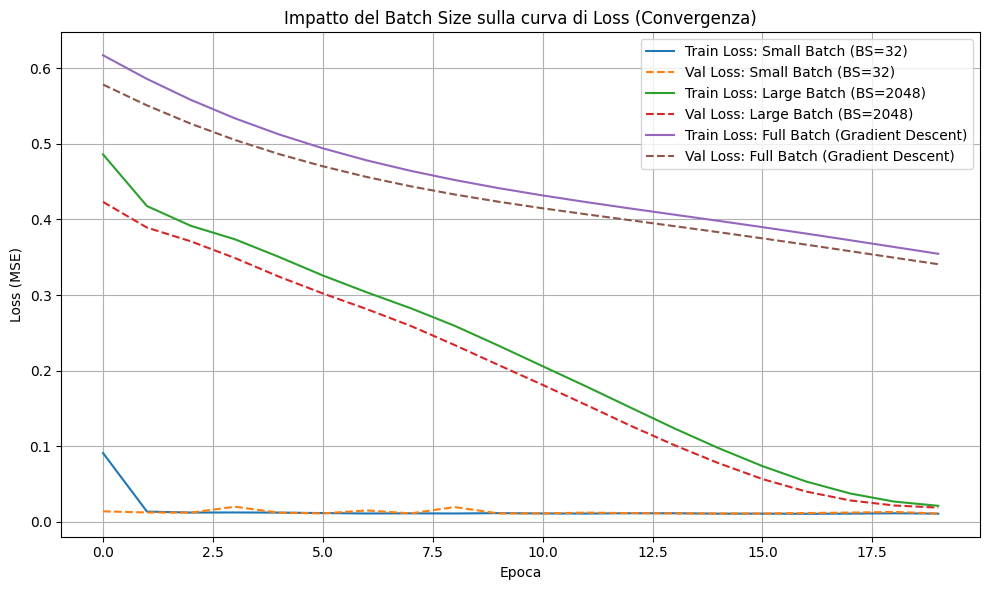

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras

# --- 1. Definizione della funzione build_model mancante ---

def build_model(input_shape, hidden_layers, activation, output_units, output_activation):
    """
    Costruisce un semplice modello Sequential Keras per la regressione.
    """
    model = keras.Sequential()
    
    # Livello di input
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    
    # Livelli nascosti
    for units in hidden_layers:
        model.add(keras.layers.Dense(units, activation=activation))
        
    # Livello di output
    model.add(keras.layers.Dense(output_units, activation=output_activation))
    
    return model

# --- 2. Generazione dei Dati (Dataset fittizio per l'esperimento) ---

# Parametri del dataset
N_SAMPLES = 5000
N_FEATURES = 10
N_VAL = 1000

# Generazione dei dati fittizi
X_full = np.random.rand(N_SAMPLES + N_VAL, N_FEATURES).astype('float32') 
# Creiamo una relazione lineare semplice per la target variable
true_weights = np.random.rand(N_FEATURES, 1).astype('float32') * 2 - 1
y_full = X_full @ true_weights + np.random.normal(0, 0.1, (N_SAMPLES + N_VAL, 1)).astype('float32')

# Divisione in Training e Validation set
X_train = X_full[:N_SAMPLES]
y_train = y_full[:N_SAMPLES]
X_val = X_full[N_SAMPLES:]
y_val = y_full[N_SAMPLES:]

print(f"Dimensione Training Set: {len(X_train)} campioni")
print(f"Dimensione Validation Set: {len(X_val)} campioni")
print("-" * 30)


# --- 3. La tua funzione di esperimento modificata ---

def run_experiment(batch_size, label):
    print(f"Training con Batch Size: {batch_size}")
    # Creiamo un modello fresco ogni volta
    # (10,) è l'input_shape corretto per il nostro X_train con 10 features
    model = build_model((N_FEATURES,), [64, 32], 'relu', 1, 'linear')
    model.compile(optimizer='adam', loss='mse')
    
    # Salviamo la storia del training
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=20,                    # Poche epoche per vedere la velocità iniziale
        batch_size=batch_size,
        verbose=0                     # Silenzioso per pulizia
    )
    return history.history['loss'], history.history['val_loss'], label

# --- 4. Esecuzione degli esperimenti ---

# Confrontiamo 3 strategie
# Utilizziamo una lista di dizionari per una gestione più pulita dei risultati
experiments = [
    run_experiment(32, "Small Batch (BS=32)"),
    run_experiment(2048, "Large Batch (BS=2048)"),
    run_experiment(len(X_train), "Full Batch (Gradient Descent)") # Batch Size = Dimensione del Training Set
]

print("-" * 30)

# --- 5. Visualizzazione ---

plt.figure(figsize=(10, 6))

for loss, val_loss, label in experiments:
    # Plottiamo le curve di Loss sul Training Set
    plt.plot(loss, label=f'Train Loss: {label}')
    # Plottiamo le curve di Loss sul Validation Set in linea tratteggiata per distinzione
    plt.plot(val_loss, label=f'Val Loss: {label}', linestyle='--')

plt.title("Impatto del Batch Size sulla curva di Loss (Convergenza)")
plt.xlabel("Epoca")
plt.ylabel("Loss (MSE)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

**Cosa osserverete:**

1.  **Batch 32:** La loss scende rapidissimamente nelle prime epoche (perché fa migliaia di aggiornamenti pesi per epoca), ma la curva è "seghettata" (rumorosa).
2.  **Batch 2048:** La loss scende molto lentamente (pochi aggiornamenti per epoca), curva molto liscia. Spesso raggiunge una loss finale peggiore (più alta) rispetto al batch piccolo.

Shape Input: 8 features
Epoch 1/20


c:\Users\mbagn\anaconda3\envs\dl\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.2225 - mae: 0.7478 - val_loss: 0.5863 - val_mae: 0.5138
Epoch 2/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4643 - mae: 0.4888 - val_loss: 0.6339 - val_mae: 0.4602
Epoch 3/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3979 - mae: 0.4509 - val_loss: 0.3661 - val_mae: 0.4360
Epoch 4/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3734 - mae: 0.4357 - val_loss: 0.8311 - val_mae: 0.4426
Epoch 5/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3646 - mae: 0.4277 - val_loss: 1.1764 - val_mae: 0.4426
Epoch 6/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3584 - mae: 0.4224 - val_loss: 0.4325 - val_mae: 0.4155
Epoch 7/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3462 - mae: 0.4159 - val_loss: 0.7126 - val_mae: 0.4222
Epoch 8/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3423 - mae: 0.4118 - val_loss: 0.4839 - val_mae: 0.4071
Epoch 9/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3333 

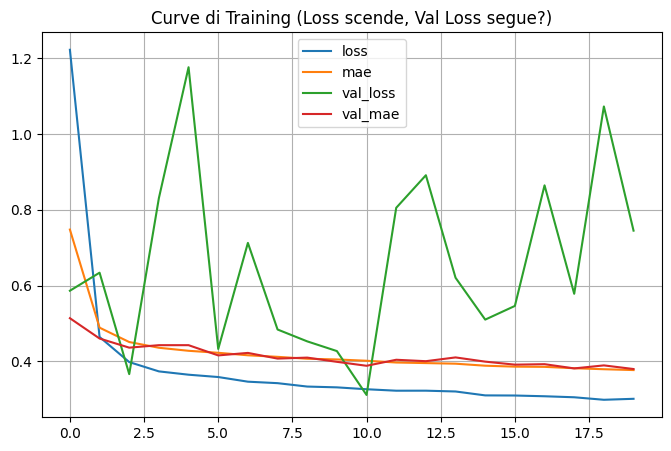

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# --- 1. PREPARAZIONE DATI ---
# Carichiamo il dataset
housing = fetch_california_housing()
X, y = housing.data, housing.target

# Split Train/Test (Fondamentale per valutare l'overfitting)
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

# !!! PASSAGGIO CRUCIALE !!!
# A differenza dei Decision Tree, le Reti Neurali richiedono input scalati.
# Se non lo fate, i gradienti esploderanno o il training sarà lentissimo.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

print(f"Shape Input: {X_train.shape[1]} features") # Dovrebbe essere 8

# --- 2. COSTRUZIONE MODELLO (Architecture Design) ---
model_reg = models.Sequential([
    # Input Layer implicito nella definizione del primo Dense
    # Struttura a "Imbuto": Partiamo larghi e stringiamo
    layers.Dense(32, activation="relu", input_shape=X_train.shape[1:]),
    
    # Secondo strato hidden per catturare non-linearità complesse
    layers.Dense(16, activation="relu"),
    
    # OUTPUT LAYER (Regressione)
    # 1 solo neurone (prezzo). 
    # Nessuna attivazione (può essere qualsiasi valore positivo).
    layers.Dense(1) 
])

# --- 3. COMPILAZIONE (Il cervello) ---
model_reg.compile(
    loss="mse",                # Mean Squared Error: standard per regressione
    optimizer="adam",          # Adam gestisce il learning rate da solo
    metrics=["mae"]            # Monitoriamo l'errore assoluto (più leggibile dell'MSE)
)

# --- 4. TRAINING (Il sudore) ---
history = model_reg.fit(
    X_train, y_train,
    epochs=20,                 # Proviamo 20 giri completi
    batch_size=32,             # Aggiorniamo i pesi ogni 32 case
    validation_data=(X_valid, y_valid), # Controllo in tempo reale
    verbose=1
)

# --- 5. ANALISI DEI RISULTATI ---
# Valutazione finale sul Test Set (dati mai visti)
mse_test, mae_test = model_reg.evaluate(X_test, y_test)
print(f"\nErrore Medio Assoluto sul Test Set: {mae_test:.2f} (in centinaia di migliaia di $)")

# Visualizzazione della curva di apprendimento
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.title("Curve di Training (Loss scende, Val Loss segue?)")
plt.show()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10


c:\Users\mbagn\anaconda3\envs\dl\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8269 - loss: 0.4849 - val_accuracy: 0.8680 - val_loss: 0.3798
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8672 - loss: 0.3619 - val_accuracy: 0.8652 - val_loss: 0.3624
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8801 - loss: 0.3260 - val_accuracy: 0.8770 - val_loss: 0.3286
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8880 - loss: 0.3001 - val_accuracy: 0.8856 - val_loss: 0.3151
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8941 - loss: 0.2846 - val_accuracy: 0.8870 - val_loss: 0.3069
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8987 - loss: 0.2707 - val_accuracy: 0.8864 - val_loss: 0.3090
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9041 - loss: 0.2571 - val_accuracy: 0.8954 - val_loss: 0.2941
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9062 - loss: 0.2485 - val_accurac

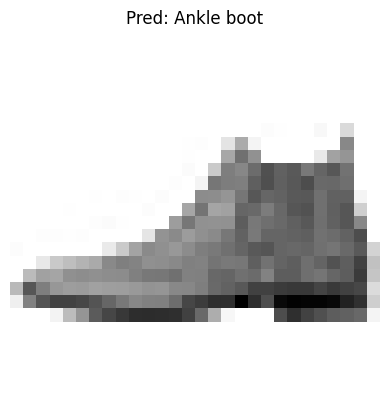

Imm 1: Reale=Pullover | Predetto=Pullover (99.9%)


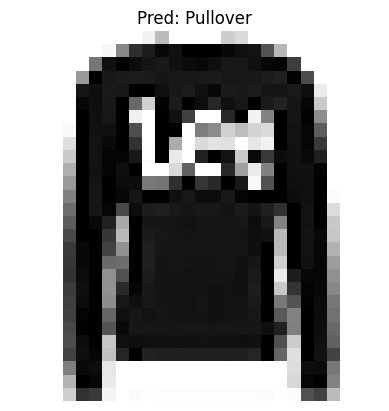

Imm 2: Reale=Trouser | Predetto=Trouser (100.0%)


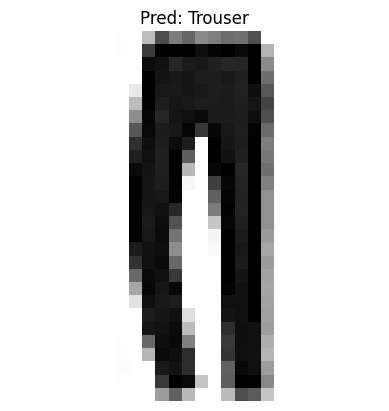

In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np

# --- 1. PREPARAZIONE DATI ---
# Keras ha questo dataset integrato
fashion_mnist = tf.keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

# Creiamo un set di validazione e SCALIAMO I PIXEL
# I pixel vanno da 0 a 255. Le reti neurali amano numeri tra 0 e 1.
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.0

class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# --- 2. COSTRUZIONE MODELLO ---
model_clf = models.Sequential([
    # PASSO FONDAMENTALE: Flattening
    # L'input è (28, 28). Dense vuole vettori piatti.
    # Flatten trasforma (28, 28) -> (784,)
    layers.Flatten(input_shape=[28, 28]),
    
    # Hidden Layer: 300 neuroni (più capacità per le immagini)
    layers.Dense(300, activation="relu"),
    
    # Secondo Hidden Layer
    layers.Dense(100, activation="relu"),
    
    # OUTPUT LAYER (Classificazione)
    # 10 neuroni = 10 classi possibili.
    # Softmax = La somma delle uscite farà 1.0 (100% probabilità).
    layers.Dense(10, activation="softmax")
])

# --- 3. COMPILAZIONE ---
model_clf.compile(
    # Usiamo "sparse" perché y_train sono interi (es. 5, 9, 0)
    # Se fossero vettori one-hot ([0,0,0,0,1...]), useremmo "categorical_crossentropy"
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"] # Vogliamo sapere la % di risposte esatte
)

# --- 4. TRAINING ---
history = model_clf.fit(
    X_train, y_train,
    epochs=10,
    validation_data=(X_valid, y_valid)
)

# --- 5. PREDIZIONE "NEL MONDO REALE" ---
# Prendiamo le prime 3 immagini del test set
X_new = X_test[:3]
y_proba = model_clf.predict(X_new)

print("\n--- Analisi Predizioni ---")
# y_proba restituisce 10 probabilità per ogni immagine. Usiamo argmax per trovare la vincente.
y_pred = np.argmax(y_proba, axis=1)

for i in range(3):
    true_label = class_names[y_test[i]]
    predicted_label = class_names[y_pred[i]]
    confidence = np.max(y_proba[i]) * 100
    
    print(f"Imm {i}: Reale={true_label} | Predetto={predicted_label} ({confidence:.1f}%)")
    
    # Visualizziamo l'immagine
    plt.imshow(X_new[i], cmap="binary")
    plt.axis('off')
    plt.title(f"Pred: {predicted_label}")
    plt.show()

### 1\. Il Paziente sul Tavolo: L'Oggetto `History`

Quando lanciate `model.fit()`, non state solo "facendo girare il codice". State generando una cartella clinica dettagliata del processo di apprendimento. La funzione `.fit()` restituisce un oggetto **History** che contiene un dizionario (`history.history`) con i valori di *loss* e *metrics* salvati alla fine di ogni epoca.

Prima di ottimizzare, dobbiamo imparare a leggere questi segnali vitali.

#### Analisi delle Curve: I Tre Scenari

Usando `matplotlib` per tracciare Training Loss (i dati che la rete vede) vs Validation Loss (i dati che la rete NON vede), incontrerete tre situazioni:

1.  **Underfitting (Il modello non impara):**

      * *Sintomo:* Sia la Training Loss che la Validation Loss rimangono alte e piatte, oppure scendono in modo esasperatamente lento.
      * *Diagnosi:* La rete è troppo stupida per il problema.
      * *Cura:* Aumentare la complessità (più strati, più neuroni) o cambiare architettura.

2.  **Il "Good Fit" (L'obiettivo):**

      * *Sintomo:* Entrambe le curve scendono rapidamente all'inizio e poi si stabilizzano insieme, quasi toccandosi.
      * *Diagnosi:* Il modello sta generalizzando bene.

3.  **Overfitting (Il modello memorizza):**

      * *Sintomo:* La Training Loss continua a scendere (va verso 0), ma la Validation Loss smette di scendere e **inizia a risalire**.
      * *Il "Divario" (Generalization Gap):* Lo spazio che si crea tra le due curve è la misura esatta di quanto la vostra rete stia "barando", memorizzando gli esempi di training invece di capire le regole.
      * *Diagnosi:* La rete è troppo complessa o state addestrando per troppe epoche.

-----

### 2\. Keras Callbacks: Il Pilota Automatico

Nel ML classico (es. Random Forest), lanciate il training e aspettate che finisca. Nel Deep Learning, il training è un processo dinamico che può durare ore o giorni. Non potete stare davanti al monitor a guardare i numeri scorrere.

I **Callbacks** sono oggetti che passate al modello e che agiscono **durante** il training (alla fine di ogni epoca o batch). Sono i vostri "agenti intelligenti" che possono fermare il training, salvare il lavoro o aggiustare i parametri in corsa.

Ecco la "Trinità" dei Callbacks che ogni ingegnere deve conoscere:

#### A. `EarlyStopping`: Il Freno d'Emergenza

Perché indovinare il numero di epoche? Impostate `epochs=1000` e dite a Keras: *"Se la Validation Loss non migliora per X epoche di fila, fermati"*.

  * **Patience:** È il parametro cruciale. Se `patience=5`, il modello aspetterà 5 epoche di peggioramento (o stallo) prima di fermarsi. È necessario perché la discesa del gradiente è rumorosa (stocastica): a volte la loss sale un po' per poi scendere molto.
  * **Restore Best Weights:** Fondamentale. Se il training si ferma all'epoca 50 perché è peggiorato dalla 40, volete che il modello in memoria torni allo stato dell'epoca 40, non che rimanga alla 50 (overfittata).

#### B. `ModelCheckpoint`: La Macchina del Tempo

Spesso il modello "migliore" non è l'ultimo. Magari all'epoca 30 eravate perfetti, e all'epoca 35 avete iniziato l'overfitting.
Questo callback salva il modello su disco (file `.keras` o `.h5`) **ogni volta che si batte un record** (es. minima val\_loss mai vista).

  * **Save Best Only:** Se `True`, sovrascrive il file solo se il modello attuale è migliore del precedente salvato. Risparmia spazio e garantisce di avere solo la versione "top".

#### C. `ReduceLROnPlateau`: La Sintonia Fine

A volte il modello smette di migliorare non perché ha finito di imparare, ma perché il Learning Rate è troppo alto e sta "rimbalzando" intorno al minimo senza entrarci.
Questo callback monitora la loss: se non scende per un po' (es. 3 epoche), divide il learning rate (es. per 10).

  * *Effetto visivo:* Vedrete la curva di loss piatta, poi improvvisamente un crollo verticale appena il LR si riduce. È come cambiare marcia per parcheggiare con precisione.

-----

### 3\. Laboratorio Pratico: Implementazione della Strategia Completa

Creiamo una simulazione di overfitting intenzionale (pochi dati, rete complessa) e usiamo i Callbacks per gestirlo.


c:\Users\mbagn\anaconda3\envs\dl\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Inizio Training...

Epoch 1: val_loss improved from None to 0.69729, saving model to best_model.keras

Epoch 2: val_loss did not improve from 0.69729

Epoch 3: val_loss did not improve from 0.69729

Epoch 4: val_loss did not improve from 0.69729

Epoch 5: val_loss did not improve from 0.69729

Epoch 6: val_loss did not improve from 0.69729

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 7: val_loss did not improve from 0.69729

Epoch 8: val_loss did not improve from 0.69729

Epoch 9: val_loss did not improve from 0.69729

Epoch 10: val_loss did not improve from 0.69729

Epoch 11: val_loss did not improve from 0.69729

Epoch 11: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.


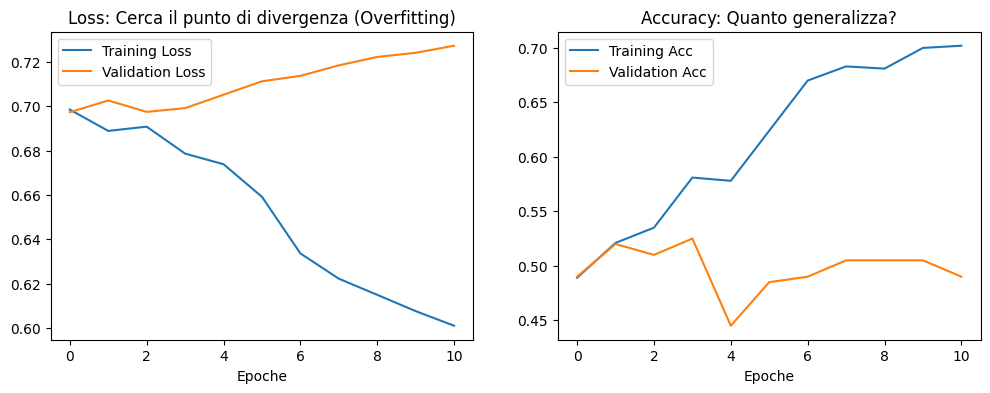

In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt
import numpy as np

# 1. Generiamo dati finti "difficili" (Rumorosi)
# 1000 esempi, 20 features
X_train = np.random.rand(1000, 20)
y_train = np.random.randint(0, 2, size=(1000, 1))
X_val = np.random.rand(200, 20)
y_val = np.random.randint(0, 2, size=(200, 1))

# 2. Definiamo un modello intenzionalmente TROPPO GROSSO (per causare overfitting)
def build_overfit_model():
    model = models.Sequential([
        layers.Dense(512, activation='relu', input_shape=(20,)),
        layers.Dense(256, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_overfit_model()

# 3. DEFINIZIONE DEI CALLBACKS (La parte cruciale)
my_callbacks = [
    # A. EarlyStopping: Fermati se non migliori per 10 epoche
    callbacks.EarlyStopping(
        monitor='val_loss',         # Cosa guardare
        patience=10,                # Quanta pazienza avere
        restore_best_weights=True,  # Alla fine, torna alla versione migliore
        verbose=1
    ),
    
    # B. ModelCheckpoint: Salva il campione
    callbacks.ModelCheckpoint(
        filepath='best_model.keras',
        monitor='val_loss',
        save_best_only=True,        # Salva solo se batti il record
        verbose=1
    ),
    
    # C. ReduceLROnPlateau: Se ti blocchi, rallenta
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,                 # Moltiplica LR attuale per 0.1
        patience=5,                 # Agisci prima dell'EarlyStopping (5 vs 10)
        min_lr=1e-6,                # Non scendere sotto questo valore
        verbose=1
    )
]

# 4. TRAINING CON "PILOTA AUTOMATICO"
print("Inizio Training...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,             # Mettiamo tante epoche, tanto ci fermeremo prima
    batch_size=32,
    callbacks=my_callbacks, # Passiamo la lista qui!
    verbose=0               # Silenzioso per leggere i print dei callback
)

# 5. VISUALIZZAZIONE DIAGNOSTICA
def plot_learning_curves(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(12, 4))
    
    # Grafico Loss
    plt.subplot(1, 2, 1)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss: Cerca il punto di divergenza (Overfitting)')
    plt.xlabel('Epoche')
    plt.legend()
    
    # Grafico Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(acc, label='Training Acc')
    plt.plot(val_acc, label='Validation Acc')
    plt.title('Accuracy: Quanto generalizza?')
    plt.xlabel('Epoche')
    plt.legend()
    
    plt.show()

plot_learning_curves(history)

### 1\. Weight Initialization: Come nasce una rete (Il primo battito)

Prima ancora di iniziare l'addestramento, dobbiamo assegnare un valore iniziale ai pesi $w$. Questa scelta, apparentemente banale, può condannare la rete ancor prima della prima epoca.

#### Il Tabù dello Zero

Domanda classica: *"Perché non inizializziamo tutti i pesi a 0?"*
Se $w = 0$, ogni neurone calcola $w \cdot x = 0$.
L'output è identico per tutti. Il gradiente calcolato durante la backpropagation sarà identico per tutti.
**Risultato:** I neuroni si aggiornano tutti allo stesso modo. Avete creato una rete di "cloni". Non importa quanto sia profonda la rete, si comporterà come se avesse 1 solo neurone per strato. Questo fenomeno si chiama **Simmetria**, e dobbiamo romperla (Symmetry Breaking).

#### Il caos controllato: Glorot vs He

Dobbiamo usare numeri casuali. Ma quanto grandi?

  * Se i pesi sono troppo piccoli: Il segnale si attenua strato dopo strato $\rightarrow$ **Vanishing Gradient**.
  * Se i pesi sono troppo grandi: Il segnale esplode e satura le attivazioni $\rightarrow$ **Exploding Gradient**.

La soluzione matematica è mantenere la varianza dell'input uguale alla varianza dell'output. Esistono due "ricette" standard basate sulla funzione di attivazione che usate:

1.  **Glorot Initialization (o Xavier):**

      * *Best Friend:* **Sigmoid** o **Tanh**.
      * *Logica:* Ottimizzata per funzioni che sono lineari vicino allo zero.
      * *Keras:* `kernel_initializer='glorot_normal'` (Spesso è il default).

2.  **He Initialization (Kaiming):**

      * *Best Friend:* **ReLU** (e varianti).
      * *Logica:* Poiché la ReLU "uccide" (azzera) metà degli input (tutti i negativi), dimezza la varianza del segnale. La He Init compensa questo moltiplicando i pesi casuali per $\sqrt{2}$.
      * *Keras:* `kernel_initializer='he_normal'`.

**Regola pratica:** Se usate ReLU (il 90% delle volte), dovete cambiare l'inizializzazione di default di Keras in `he_normal`.

-----

### 2\. Batch Normalization: Il "Reset" Interno

Addestrare una rete profonda è come giocare al "telefono senza fili". Il primo strato cambia i suoi pesi -\> cambia l'output che manda al secondo strato -\> il secondo strato deve ri-adattarsi a una nuova distribuzione di dati, e così via. Questo continuo inseguimento si chiama **Internal Covariate Shift**.

La **Batch Normalization (BN)** risolve questo problema forzando i dati, all'interno di ogni strato, ad avere **Media 0 e Varianza 1**.

  * **Cosa fa:** Sottrae la media del batch e divide per la deviazione standard. Poi applica due parametri imparabili ($\gamma$ per scalare, $\beta$ per traslare) per permettere alla rete di "disfare" la normalizzazione se necessario.
  * **L'Effetto Magico:**
    1.  La Loss scende molto più velocemente.
    2.  Diventa molto difficile che i gradienti esplodano.
    3.  Potete usare un **Learning Rate molto più alto** (es. 0.01 invece di 0.0001).

#### Il Dibattito: Prima o dopo l'attivazione?

C'è una discussione accademica in corso, ma l'approccio ingegneristico più robusto (suggerito dall'autore originale) è:

1.  Calcolo Lineare ($w \cdot x + b$)
2.  Batch Normalization (Riscala tutto)
3.  Attivazione (ReLU)

*Nota Pro:* Se usate la BN prima dell'attivazione, il "bias" del layer Dense diventa inutile (perché la BN sottrae la media, cancellando il bias $b$). Quindi si usa `Dense(..., use_bias=False)`.

-----

### 3\. Dropout: L'Arte di Dimenticare

Le reti neurali sono macchine da memorizzazione. Se date loro abbastanza tempo, impareranno a memoria il rumore del dataset.
Il **Dropout** è una tecnica brutale di regolarizzazione. Durante il training, ad ogni passaggio, **spegne casualmente** una percentuale di neuroni (li mette a zero).

  * **Metafora:** Immaginate un'azienda dove ogni giorno il 20% dei dipendenti non viene al lavoro a caso. Per funzionare, l'azienda non può affidare compiti critici a una sola persona. Tutti devono saper fare un po' tutto. Si crea **Ridondanza**.

  * **Risultato:** La rete non può basarsi su un singolo neurone per una feature ("Se il neurone 5 è acceso, è un gatto"). Deve distribuire la conoscenza.

  * **Dove:** Solitamente dopo l'attivazione (o dopo il Pooling nelle CNN).

  * **Rate:**

      * `0.2` (20%): Leggero. Buono per i primi strati.
      * `0.5` (50%): Aggressivo. Standard per gli strati densi finali dove ci sono più parametri.

-----

### 4\. Laboratorio Pratico: Costruire la Rete "Inaffondabile"

Costruiamo una rete che implementa tutte queste best practices. Questa architettura è robusta e adatta a quasi ogni problema tabellare complesso.




In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_robust_model(input_shape, num_classes):
    model = models.Sequential(name="Robust_Network")
    
    model.add(layers.Input(shape=input_shape))
    
    # --- BLOCCO 1: Deep & Stable ---
    # 1. Dense: Usiamo He Normal perché useremo ReLU
    #    use_bias=False perché la Batch Norm ha già il suo parametro 'beta' (shift)
    model.add(layers.Dense(64, kernel_initializer='he_normal', use_bias=False))
    
    # 2. Batch Normalization: Normalizza PRIMA di attivare
    model.add(layers.BatchNormalization())
    
    # 3. Activation: Ora applichiamo la non-linearità
    model.add(layers.Activation('relu'))
    
    # 4. Dropout: Leggero (20%) per non perdere troppe info iniziali
    model.add(layers.Dropout(0.2))
    
    # --- BLOCCO 2: Ancora più profondo ---
    model.add(layers.Dense(32, kernel_initializer='he_normal', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(0.3)) # Aumentiamo un po' il dropout
    
    # --- OUTPUT BLOCK ---
    # Nota: Sull'output NON usiamo Batch Norm o Dropout solitamente.
    # Vogliamo le predizioni pure.
    # Inizializzazione Glorot perché usiamo Softmax (simile a Sigmoid)
    model.add(layers.Dense(num_classes, 
                           kernel_initializer='glorot_normal', 
                           activation='softmax'))
    
    return model

# Testiamo la costruzione
model = build_robust_model(input_shape=(50,), num_classes=10)

# Compiliamo con un Learning Rate più aggressivo grazie alla Batch Norm
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01) 

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer)

model.summary()

Model: "Robust_Network"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_25 (Dense)                │ (None, 64)             │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 32)             │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,962 (23.29 KB)

 Trainable params: 5,770 (22.54 KB)

 Non-trainable params: 192 (768.00 B)

### Modulo 6: Hyperparameter Tuning Automatico

**Obiettivo:** Smettere di indovinare i numeri a caso.

Fino ad ora abbiamo scelto il numero di neuroni ($32, 64$), il Learning Rate ($0.001$) e il Dropout ($0.2$) basandoci sull'intuito o copiando tutorial. Ma chi ci dice che $0.001$ sia meglio di $0.0005$?

Il **Tuning** manuale è inefficiente e noioso. **Keras Tuner** è una libreria che automatizza questo processo: voi definite le "regole del gioco" (i range possibili), e lui cerca la combinazione vincente mentre voi andate a prendere un caffè.

#### 1\. Definire lo Spazio di Ricerca (The Search Space)

Invece di costruire un modello fisso, costruiamo un **Iper-Modello**.
All'interno della nostra funzione di costruzione, sostituiamo i numeri fissi con metodi dell'oggetto `hp` (HyperParameters):

  * **`hp.Int('nome', min, max, step)`:** Per valori numerici discreti (es. numero di neuroni, numero di strati).
  * **`hp.Choice('nome', values=[...])`:** Per scelte categoriche (es. 'relu' vs 'tanh', o l'optimizer).
  * **`hp.Float('nome', min, max, sampling='log')`:** Per valori continui.
      * *Nota Pro:* Per il Learning Rate, usate sempre `sampling='log'`. La differenza tra $0.1$ e $0.01$ è molto più impattante della differenza tra $0.5$ e $0.6$. Il campionamento logaritmico esplora le *magnitudini*.

#### 2\. Le Strategie di Ricerca

Una volta definiti i range, come li esploriamo?

  * **Random Search:**
    Sceglie combinazioni a caso.

      * *Perché funziona:* In uno spazio ad alta dimensionalità, la ricerca casuale è spesso più efficiente della Grid Search (provare tutte le combinazioni), perché non spreca tempo a testare variazioni minuscole di parametri inutili.

  * **Hyperband (Il Torneo):**
    È la strategia stato dell'arte per velocità. Funziona come un torneo ad eliminazione diretta (stile *Squid Game*):

    1.  Genera 100 modelli con iperparametri diversi.
    2.  Li addestra tutti per poche epoche (es. 2).
    3.  Scarta la metà peggiore.
    4.  Addestra i sopravvissuti per altre epoche.
    5.  Ripete finché non ne resta uno.

    <!-- end list -->

      * *Vantaggio:* Non spreca risorse per addestrare fino in fondo modelli che sono partiti male.

-----

### 3\. Laboratorio Pratico: Keras Tuner in Azione

Prima di eseguire questo codice, assicuratevi di aver installato la libreria: `pip install keras-tuner`.



In [16]:

import tensorflow as tf
from tensorflow.keras import layers, models
import keras_tuner as kt

# Caricamento del dataset MNIST
(X_train, y_train), (X_val, y_val) = tf.keras.datasets.mnist.load_data()

# Normalizzazione dei pixel (da 0-255 a 0-1)
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0

# Verifica delle dimensioni (dovrebbe stampare (60000, 28, 28))
print(f"Dimensione X_train: {X_train.shape}")

# 1. Definiamo l'Iper-Modello
def build_hyper_model(hp):
    model = models.Sequential()
    model.add(layers.Flatten(input_shape=(28, 28))) # Esempio su MNIST
    
    # TUNING 1: Il numero di strati nascosti (tra 1 e 3)
    # hp.Int crea un ciclo for implicito
    for i in range(hp.Int('num_layers', 1, 3)):
        
        # TUNING 2: Numero di neuroni per ogni strato (da 32 a 256 a passi di 32)
        model.add(layers.Dense(
            units=hp.Int(f'units_{i}', min_value=32, max_value=256, step=32),
            activation='relu'
        ))
        
        # TUNING 3: Dropout condizionale (Booleano)
        if hp.Boolean("dropout"):
            model.add(layers.Dropout(rate=0.25))
            
    model.add(layers.Dense(10, activation='softmax'))
    
    # TUNING 4: Learning Rate (Logaritmico)
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# 2. Inizializziamo il Tuner (L'arbitro)
tuner = kt.Hyperband(
    build_hyper_model,
    objective='val_accuracy', # Cosa vogliamo massimizzare?
    max_epochs=10,            # Max epoche per il "vincitore"
    factor=3,                 # Fattore di riduzione (scarta 1/3 ogni round)
    directory='my_dir',       # Dove salvare i risultati
    project_name='intro_to_kt'
)

# Un callback per pulire l'output durante la ricerca
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# 3. AVVIARE LA RICERCA (Simile a model.fit)
print("Inizio la ricerca del modello perfetto...")
tuner.search(
    X_train, y_train, 
    epochs=10, 
    validation_data=(X_val, y_val), 
    callbacks=[stop_early]
)

# 4. ESTRARRE IL VINCITORE
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Il tuning è completo!
- Strati ottimali: {best_hps.get('num_layers')}
- Neuroni primo strato: {best_hps.get('units_0')}
- Learning Rate ottimale: {best_hps.get('lr')}
""")

# 5. RETRAINING DEL MODELLO MIGLIORE
# Costruiamo il modello con i parametri vincenti e lo addestriamo da zero
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val))


Trial 26 Complete [00h 00m 35s]
val_accuracy: 0.9555000066757202

Best val_accuracy So Far: 0.980400025844574
Total elapsed time: 00h 09m 27s

Il tuning è completo!
- Strati ottimali: 2
- Neuroni primo strato: 224
- Learning Rate ottimale: 0.00021818909618719082

Epoch 1/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8712 - loss: 0.4390 - val_accuracy: 0.9477 - val_loss: 0.1724
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9439 - loss: 0.1903 - val_accuracy: 0.9604 - val_loss: 0.1228
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9580 - loss: 0.1418 - val_accuracy: 0.9703 - val_loss: 0.0949
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9662 - loss: 0.1099 - val_accuracy: 0.9736 - val_loss: 0.0823
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9722 - loss: 0.0918 - val_accuracy: 0.9766 - val_loss: 0.0732
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9758 - loss: 0.079



Il dataset è il **California Housing** (regressione). L'obiettivo è minimizzare l'errore sul prezzo delle case.


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import keras_tuner as kt

# --- 1. DATA LOADING & SPLITTING ---
print("Caricamento e preparazione dati...")
data = fetch_california_housing()
X, y = data.data, data.target

# Split Train (70%) / Validation (15%) / Test (15%)
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.176, random_state=42) # 0.176 of 0.85 is ~0.15

# --- 2. SCALING (Fondamentale per Modulo 1) ---
# Calcoliamo media e varianza SOLO sul training set per evitare Data Leakage
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print(f"Dataset pronto. Feature shape: {X_train.shape}")

Caricamento e preparazione dati...
Dataset pronto. Feature shape: (14456, 8)


#### Fase 1: Definizione dell'Iper-Modello (Moduli 1, 4, 6)

Qui definiamo non "una" rete, ma lo **spazio delle possibili reti**. Integriamo le best practices di regolarizzazione.

In [18]:
def build_advanced_model(hp):
    """
    Costruisce un modello compilato esplorando lo spazio degli iperparametri.
    Include: He Init, BatchNormalization, Dropout e Tuning del LR.
    """
    model = models.Sequential()
    
    # Input Layer esplicito
    model.add(layers.Input(shape=X_train.shape[1:]))
    
    # --- HYPERPARAMETER: Profondità della rete ---
    # Cerchiamo tra 1 e 4 hidden layers
    for i in range(hp.Int('num_layers', 1, 4)):
        
        # --- HYPERPARAMETER: Larghezza (Width) ---
        units = hp.Int(f'units_{i}', min_value=32, max_value=512, step=32)
        
        # --- BEST PRACTICE: Block Design (Modulo 4) ---
        # 1. Dense (senza bias se usiamo Batch Norm) + He Initialization
        model.add(layers.Dense(
            units=units,
            kernel_initializer='he_normal', # Ottimizzato per ReLU
            use_bias=False # La BN ha già un parametro beta (bias)
        ))
        
        # 2. Batch Normalization (Opzionale nel tuning)
        if hp.Boolean('use_batch_norm'):
            model.add(layers.BatchNormalization())
        
        # 3. Activation (ReLU standard o Swish per i più moderni)
        model.add(layers.Activation('relu'))
        
        # 4. Dropout (Opzionale e tunabile)
        dropout_rate = hp.Float(f'dropout_{i}', 0.0, 0.5, step=0.1)
        if dropout_rate > 0:
            model.add(layers.Dropout(dropout_rate))
            
    # --- OUTPUT LAYER (Modulo 1) ---
    # Regressione -> 1 neurone, attivazione Linear
    model.add(layers.Dense(1, activation='linear'))
    
    # --- COMPILAZIONE (Modulo 2) ---
    # Tuning del Learning Rate (Logaritmico: 0.01, 0.001, 0.0001)
    lr = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='mse',      # Loss standard per regressione
        metrics=['mae']  # Metrica leggibile (errore in $)
    )
    
    return model

#### Fase 2: La Ricerca del Modello Perfetto (Modulo 6)

Lanciamo **Hyperband** per trovare la combinazione vincente senza dover provare tutto manualmente.

In [19]:
print("\n--- Inizio Hyperparameter Tuning ---")

tuner = kt.Hyperband(
    build_advanced_model,
    objective='val_loss', # Vogliamo minimizzare l'errore su dati non visti
    max_epochs=15,        # Le "batterie" del torneo durano max 15 epoche
    factor=3,
    directory='housing_logs',
    project_name='cali_regression_v1',
    overwrite=True
)

# Callback per fermare i modelli scarsi durante il tuning
stop_early = callbacks.EarlyStopping(monitor='val_loss', patience=3)

tuner.search(X_train, y_train, epochs=15, validation_data=(X_val, y_val), callbacks=[stop_early])

# Recuperiamo i migliori iperparametri
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Tuning Completato! Configurazione vincente:
- Layers: {best_hps.get('num_layers')}
- Learning Rate: {best_hps.get('learning_rate'):.5f}
- Use Batch Norm: {best_hps.get('use_batch_norm')}
""")

Trial 30 Complete [00h 00m 13s]
val_loss: 0.3176107406616211

Best val_loss So Far: 0.3175828754901886
Total elapsed time: 00h 03m 12s

Tuning Completato! Configurazione vincente:
- Layers: 2
- Learning Rate: 0.00337
- Use Batch Norm: False



#### Fase 3: Training Professionale (Moduli 2 & 3)

Ora che abbiamo la "ricetta" (iperparametri), costruiamo il modello pulito e lo addestriamo "sul serio" con una strategia di Callbacks completa.

In [20]:
print("\n--- Training Finale del Modello Migliore ---")

# 1. Ricostruiamo il modello con i parametri vincenti
model = tuner.hypermodel.build(best_hps)

# 2. Definiamo i Callback "Salva-Vita" (Modulo 3)
final_callbacks = [
    # A. Smetti se non migliori per 15 epoche e torna indietro
    callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=15, 
        restore_best_weights=True,
        verbose=1
    ),
    
    # B. Se ti blocchi, riduci il learning rate
    callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.2, 
        patience=5, 
        min_lr=1e-6,
        verbose=1
    ),
    
    # C. Salva il modello su disco
    callbacks.ModelCheckpoint(
        'best_cali_housing.keras', 
        save_best_only=True,
        monitor='val_loss'
    )
]

# 3. Addestramento Lungo (fino a 100 epoche, tanto c'è EarlyStopping)
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64, # Compromesso tra velocità e generalizzazione
    validation_data=(X_val, y_val),
    callbacks=final_callbacks,
    verbose=0 # Silenzioso per pulizia output
)

print(f"Training terminato all'epoca {len(history.history['loss'])}")


--- Training Finale del Modello Migliore ---

Epoch 28: ReduceLROnPlateau reducing learning rate to 0.0006749912630766631.

Epoch 40: ReduceLROnPlateau reducing learning rate to 0.00013499825727194547.

Epoch 51: ReduceLROnPlateau reducing learning rate to 2.6999652618542314e-05.

Epoch 56: ReduceLROnPlateau reducing learning rate to 5.399930523708463e-06.

Epoch 61: ReduceLROnPlateau reducing learning rate to 1.0799861229315866e-06.
Epoch 61: early stopping
Restoring model weights from the end of the best epoch: 46.
Training terminato all'epoca 61


#### Fase 4: Diagnostica e Valutazione (Modulo 3)

Non ci fidiamo solo dei numeri. Vogliamo vedere i grafici.


Risultati Test Set:
MAE (Errore Medio): 0.3762 (Centinaia di migliaia di $)
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step


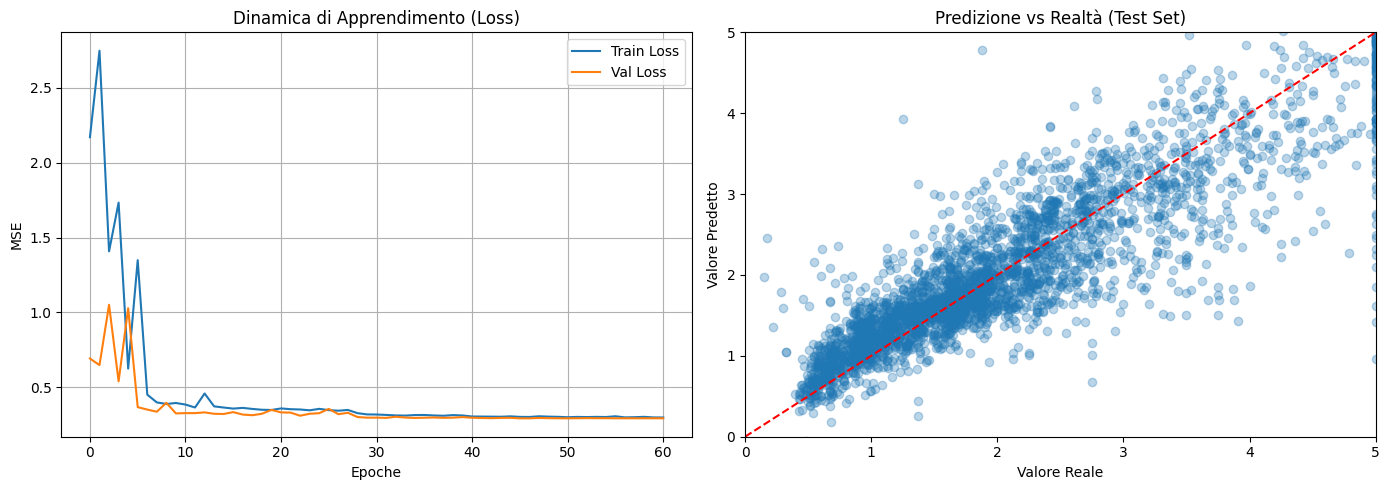


Esempio di predizione:
Reale: 0.48 | Predetto: 0.52 | Errore: 0.05


In [21]:
# --- VALUTAZIONE SUL TEST SET (La prova del nove) ---
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"\nRisultati Test Set:")
print(f"MAE (Errore Medio): {test_mae:.4f} (Centinaia di migliaia di $)")

# --- VISUALIZZAZIONE ---
plt.figure(figsize=(14, 5))

# Grafico 1: Curve di Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Dinamica di Apprendimento (Loss)')
plt.xlabel('Epoche')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)

# Grafico 2: Predizioni vs Realtà
plt.subplot(1, 2, 2)
y_pred = model.predict(X_test).flatten()
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([0, 5], [0, 5], 'r--') # Linea ideale perfetta
plt.title('Predizione vs Realtà (Test Set)')
plt.xlabel('Valore Reale')
plt.ylabel('Valore Predetto')
plt.xlim(0, 5); plt.ylim(0, 5)

plt.tight_layout()
plt.show()

# Esempio pratico
print("\nEsempio di predizione:")
print(f"Reale: {y_test[0]:.2f} | Predetto: {y_pred[0]:.2f} | Errore: {abs(y_test[0] - y_pred[0]):.2f}")

Passiamo dalla **Regressione** (predire un numero continuo) alla **Classificazione Multiclasse** (predire una categoria tra 3 opzioni: Cultivar 0, 1 o 2).

Questo cambio di obiettivo modifica tre "organi vitali" della nostra pipeline:

1.  **L'Output Layer:** Non più 1 neurone lineare, ma 3 neuroni con `softmax`.
2.  **La Loss Function:** Non più `mse`, ma `sparse_categorical_crossentropy`.
3.  **La Metrica:** Non più errore assoluto, ma `accuracy`.

Inoltre, il **Wine Dataset** è molto piccolo (solo 178 campioni). Questo rende la sfida dell'**Overfitting** ancora più critica rispetto al California Housing. Useremo tecniche di regolarizzazione aggressive.

Ecco la pipeline completa.

-----

### Capstone Project: Multiclass Classification Pipeline (Wine Dataset)

#### Fase 0: Data Loading & Preprocessing

Carichiamo i dati e, come sempre, scaliamo le feature. Senza scalatura, le caratteristiche chimiche con valori alti (es. "Prolina" \~1000) dominerebbero su quelle piccole (es. "Nonflavanoid phenols" \~0.3).



In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import keras_tuner as kt

# --- 1. PREPARAZIONE DATI ---
wine = load_wine()
X, y = wine.data, wine.target
class_names = wine.target_names # ['class_0', 'class_1', 'class_2']

print(f"Dataset Wine caricato. Shape: {X.shape}")
print(f"Esempio target: {np.unique(y)} (3 Classi)")

# Split Train/Val/Test
# Dato che i dati sono pochi, usiamo stratify=y per mantenere le proporzioni delle classi
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, stratify=y_train_full, random_state=42)

# Scaling (Standardizzazione)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

Dataset Wine caricato. Shape: (178, 13)
Esempio target: [0 1 2] (3 Classi)



#### Fase 1: Iper-Modello per Classificazione (Tuning)

Notate le differenze cruciali nell'ultimo strato e nella compilazione. Dato che il dataset è piccolo, ridurremo anche lo spazio di ricerca (neuroni max 128 invece di 512) per evitare reti mostruose.

In [23]:
def build_classifier_model(hp):
    model = models.Sequential()
    model.add(layers.Input(shape=X_train.shape[1:]))
    
    # --- TUNING ARCHITETTURA ---
    # Cerchiamo tra 1 e 3 strati nascosti
    for i in range(hp.Int('num_layers', 1, 3)):
        
        # Tuning Neuroni: Teniamoci bassi (32-128) perché abbiamo pochi dati
        model.add(layers.Dense(
            units=hp.Int(f'units_{i}', min_value=32, max_value=128, step=32),
            kernel_initializer='he_normal', # ReLU friend
            use_bias=False # Per Batch Norm
        ))
        
        # Batch Norm è quasi sempre utile
        if hp.Boolean('use_batch_norm'):
            model.add(layers.BatchNormalization())
        
        model.add(layers.Activation('relu'))
        
        # Dropout è FONDAMENTALE qui (piccolo dataset = alto rischio memorizzazione)
        # Cerchiamo un dropout aggressivo tra 0.2 e 0.5
        model.add(layers.Dropout(hp.Float(f'dropout_{i}', 0.2, 0.5, step=0.1)))
            
    # --- OUTPUT LAYER (Differenza Chiave!) ---
    # 3 Neuroni (uno per classe)
    # Softmax: trasforma i numeri in probabilità che sommano a 1.0
    model.add(layers.Dense(3, activation='softmax', kernel_initializer='glorot_normal'))
    
    # --- COMPILAZIONE ---
    lr = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        # 'sparse' perché i target sono interi 0, 1, 2
        loss='sparse_categorical_crossentropy', 
        metrics=['accuracy'] # Vogliamo massimizzare l'accuratezza
    )
    
    return model

#### Fase 2: Ricerca con Hyperband

Cerchiamo di massimizzare la `val_accuracy`.


In [24]:
tuner = kt.Hyperband(
    build_classifier_model,
    objective='val_accuracy', # Obiettivo cambiato!
    max_epochs=20,            # Più epoche perché il dataset è piccolo e rumoroso
    factor=3,
    directory='wine_logs',
    project_name='wine_classification',
    overwrite=True
)

stop_early = callbacks.EarlyStopping(monitor='val_loss', patience=5)

print("--- Avvio Tuning ---")
tuner.search(X_train, y_train, epochs=20, validation_data=(X_val, y_val), callbacks=[stop_early])

best_hps = tuner.get_best_hyperparameters()[0]
print(f"\nTuning completato. Best LR: {best_hps.get('learning_rate'):.5f}")

Trial 30 Complete [00h 00m 06s]
val_accuracy: 0.7586206793785095

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 01m 51s

Tuning completato. Best LR: 0.00371


#### Fase 3: Training Finale e Callbacks

Qui impostiamo i callback per la classificazione.

In [25]:
# 1. Ricostruzione modello vincente
model = tuner.hypermodel.build(best_hps)

# 2. Callbacks
final_callbacks = [
    callbacks.EarlyStopping(
        monitor='val_loss',    # Guardiamo sempre la loss per fermarci
        patience=10, 
        restore_best_weights=True
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.2, 
        patience=5,
        verbose=1
    ),
    callbacks.ModelCheckpoint('best_wine_model.keras', save_best_only=True)
]

# 3. Training
# Usiamo un batch size piccolo (16 o 32) perché abbiamo solo ~100 esempi di training.
# Un batch size grande farebbe un solo aggiornamento per epoca!
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16, 
    validation_data=(X_val, y_val),
    callbacks=final_callbacks,
    verbose=0
)

print(f"Training finito. Epoche totali: {len(history.history['loss'])}")


Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0007412826176732779.

Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0001482565188780427.
Training finito. Epoche totali: 18


#### Fase 4: Valutazione Approfondita (Confusion Matrix)

In classificazione, un semplice numero (Accuracy 95%) non basta. Dobbiamo sapere *dove* sbaglia. Confonde il vino 1 col 2?


Test Accuracy: 100.00%


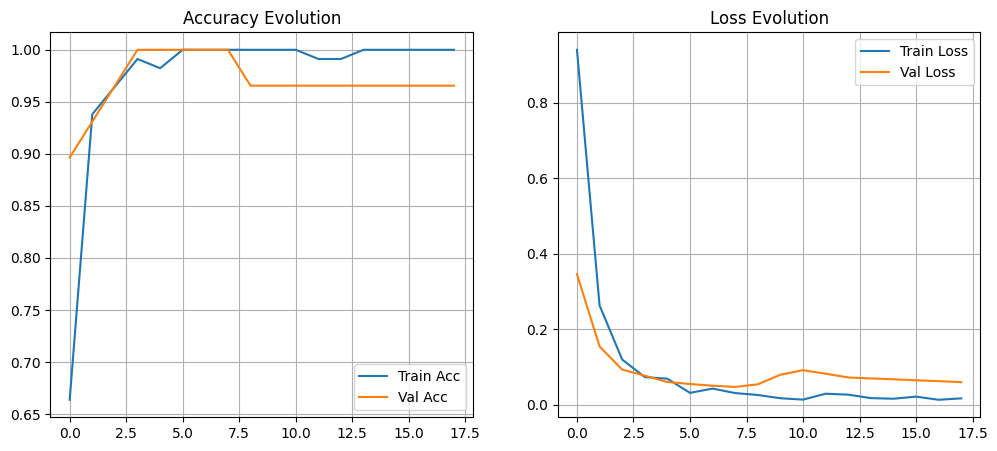

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


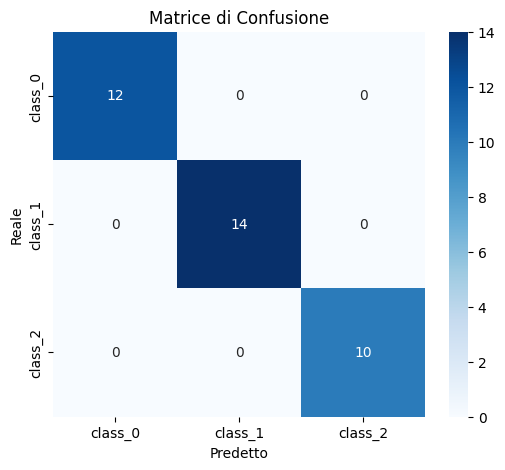


Classification Report:

              precision    recall  f1-score   support

     class_0       1.00      1.00      1.00        12
     class_1       1.00      1.00      1.00        14
     class_2       1.00      1.00      1.00        10

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36



In [26]:
# --- VALUTAZIONE SUL TEST SET ---
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Accuracy: {acc*100:.2f}%")

# --- VISUALIZZAZIONE PERFORMANCE ---
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Evolution')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Evolution')
plt.legend()
plt.grid(True)
plt.show()

# --- CONFUSION MATRIX (Strumento PRO) ---
# Otteniamo le probabilità
y_probs = model.predict(X_test)
# Convertiamo le probabilità nella classe vincente (arg max)
y_pred = np.argmax(y_probs, axis=1)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predetto')
plt.ylabel('Reale')
plt.title('Matrice di Confusione')
plt.show()

# Report testuale completo
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=class_names))